#Data Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn import tree
import pickle

In [2]:
#change the url for your own dataset
url = '/content/drive/MyDrive/bike_clean.csv'
df = pd.read_csv(url)

In [3]:
df.head()

Unnamed: 0             datetime  ... rainfall  snowfall
0           1  2017-12-01 00:00:00  ...      0.0         0
1           2  2017-12-01 01:00:00  ...      0.0         0
2           3  2017-12-01 02:00:00  ...      0.0         0
3           4  2017-12-01 03:00:00  ...      0.0         0
4           5  2017-12-01 04:00:00  ...      0.0         0

[5 rows x 16 columns]

In [4]:
df.columns

Index(['Unnamed: 0', 'datetime', 'date', 'hour', 'season', 'holiday', 'open',
       'rent_count', 'temperature', 'humidity', 'wind_speed', 'visibility',
       'dewpoint_temp', 'solar_radiation', 'rainfall', 'snowfall'],
      dtype='object')

In [5]:
# dropping the date columns and removing all rows where the bikes are not open
index_names = df[ df['open'] == "No" ].index
df.drop(index_names, inplace = True)
df.drop(columns = ["Unnamed: 0", "datetime", "hour", "open"], inplace = True)

In [6]:
columns = list(df.columns)
columns.remove('rent_count')
print(columns)

['date', 'season', 'holiday', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dewpoint_temp', 'solar_radiation', 'rainfall', 'snowfall']


In [ ]:
df.head()

date  season     holiday  ...  solar_radiation  rainfall  snowfall
0  2017-12-01  Winter  No Holiday  ...              0.0       0.0         0
1  2017-12-01  Winter  No Holiday  ...              0.0       0.0         0
2  2017-12-01  Winter  No Holiday  ...              0.0       0.0         0
3  2017-12-01  Winter  No Holiday  ...              0.0       0.0         0
4  2017-12-01  Winter  No Holiday  ...              0.0       0.0         0

[5 rows x 12 columns]

In [7]:
# combining rows by days where rent count, rainfall and snowfall are summed, the rest are combined by median
df_per_day = df.groupby(["date", "season", "holiday"], as_index = False).median()
df_per_day.drop(columns = ["rainfall", "snowfall"], inplace = True)
other = df.groupby("date", as_index = False).agg({"rent_count":"sum", "rainfall" : "sum", "snowfall" : "sum"})
df_per_day.drop(columns = ["rent_count"], inplace = True)
df_per_day = other.merge(df_per_day, on = "date")

In [8]:
df_per_day.head()

date  rent_count  rainfall  ...  visibility dewpoint_temp solar_radiation
0  2017-12-01        9539       0.0  ...     20000.0        -17.40             0.0
1  2017-12-02        8523       0.0  ...     14410.0         -5.55             0.0
2  2017-12-03        7222       4.0  ...      3380.0          2.65             0.0
3  2017-12-04        8729       0.1  ...     19130.0        -12.95             0.0
4  2017-12-05        8307       0.0  ...     20000.0        -17.70             0.0

[5 rows x 12 columns]

In [9]:
df_per_day.drop(columns = ["date"], inplace = True)

# X is the variables and y is the response
X = df_per_day.iloc[:, df_per_day.columns != "rent_count"]
y = df_per_day.iloc[:, df_per_day.columns == "rent_count"]

In [ ]:
X.head()

rainfall  snowfall  season  ... visibility  dewpoint_temp  solar_radiation
0       0.0         0  Winter  ...    20000.0         -17.40              0.0
1       0.0         0  Winter  ...    14410.0          -5.55              0.0
2       4.0         0  Winter  ...     3380.0           2.65              0.0
3       0.1         0  Winter  ...    19130.0         -12.95              0.0
4       0.0         0  Winter  ...    20000.0         -17.70              0.0

[5 rows x 10 columns]

In [10]:
# one hot encoding categorical variables

categorical_X = X.iloc[:, [2,3]]
continuous_X = X.iloc[:, [0,1] + list(range(4,10))]

categorical_encoder = OneHotEncoder(handle_unknown = "ignore")
ct = ColumnTransformer(
    transformers = [("Categorical", categorical_encoder, [0, 1])]
    , remainder = 'drop'
)
categorical_X = ct.fit_transform(categorical_X)
categorical_label = ct.get_feature_names()
categorical_X = pd.DataFrame(categorical_X, columns = categorical_label)

In [11]:
X = categorical_X.merge(continuous_X, left_index = True, right_index = True)

In [ ]:
X.head()

Categorical__x0_Autumn  ...  solar_radiation
0                     0.0  ...              0.0
1                     0.0  ...              0.0
2                     0.0  ...              0.0
3                     0.0  ...              0.0
4                     0.0  ...              0.0

[5 rows x 14 columns]

# Decision Tree (Random Forest)

## Splitting the data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
X_column_names = X_train.columns # just keeping track of the column names

In [ ]:
X_train

Categorical__x0_Autumn  ...  solar_radiation
101                     0.0  ...            0.015
202                     0.0  ...            0.290
329                     1.0  ...            0.000
181                     0.0  ...            0.505
82                      0.0  ...            0.000
..                      ...  ...              ...
71                      0.0  ...            0.000
106                     0.0  ...            0.030
270                     0.0  ...            0.020
348                     1.0  ...            0.000
102                     0.0  ...            0.020

[282 rows x 14 columns]

## Training the model

In [13]:
model = RandomForestRegressor(random_state = 42, max_depth = 3)
model.fit(X_train, np.ravel(y_train,order="c"))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

##Checking the error between prediction and test value

In [15]:
y_pred = model.predict(X_test)

In [27]:
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred, squared = False))
print('R Squared Score:', (metrics.r2_score(y_test, y_pred)))

Explained Variance Score: 0.8347360891087352
Root Mean Squared Error: 4253.675025207956
R Squared Score: 0.8344875793161559


In [ ]:
np.mean(cross_val_score(model, X_train, np.ravel(y_train,order="c"), cv=10))

0.8234254810882286

##Finding the important features

In [ ]:
#sorting them
sorted_features = []
for feature, importance in zip(X.columns, model.feature_importances_):
    sorted_features.append((feature, importance))
sorted_features.sort(key = lambda x: x[1], reverse = True)

In [ ]:
sorted_features

[('temperature', 0.6825842976093773),
 ('rainfall', 0.1560179459812098),
 ('Categorical__x0_Autumn', 0.04251372789034712),
 ('Categorical__x0_Winter', 0.04154969142779014),
 ('humidity', 0.03727654670960534),
 ('solar_radiation', 0.033650527681304124),
 ('Categorical__x0_Spring', 0.0022903137016110284),
 ('visibility', 0.0021483837893111818),
 ('dewpoint_temp', 0.0010043148467027859),
 ('wind_speed', 0.0007960790744512037),
 ('snowfall', 0.00016817128828995045),
 ('Categorical__x0_Summer', 0.0),
 ('Categorical__x1_Holiday', 0.0),
 ('Categorical__x1_No Holiday', 0.0)]

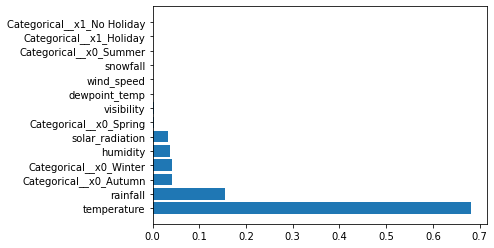

In [ ]:
plt.barh([x[0] for x in sorted_features], [y[1] for y in sorted_features])
plt.xticks(rotation='horizontal')
plt.show()

In [32]:
pip install graphviz

In [33]:
from sklearn.tree import export_graphviz

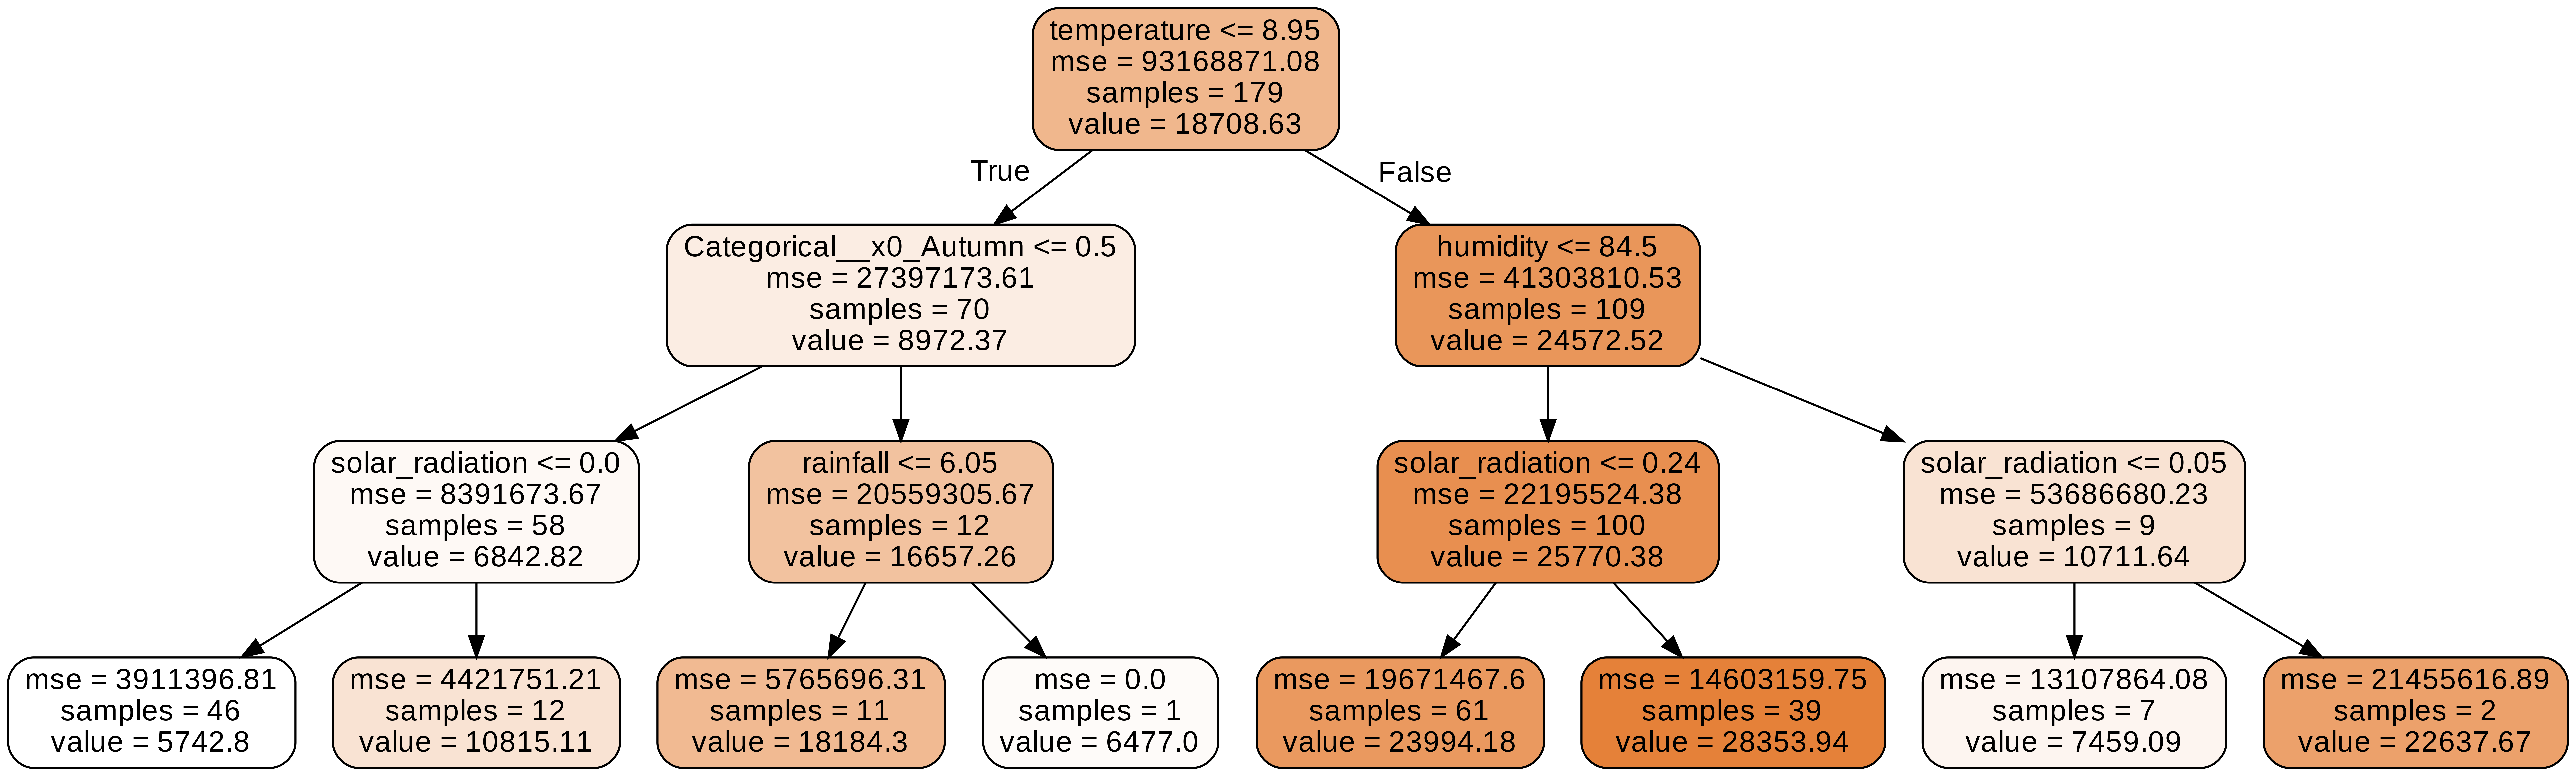

In [ ]:
# Export as dot file
export_graphviz(model.estimators_[0], out_file='tree.dot', 
                feature_names = X_column_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Parameter Tuning

In [18]:
n_estimators = np.arange(100, 2000, step=100)
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(10, 100, step=10)) + [None]
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [21]:
forest = RandomForestRegressor(random_state = 42)
random_cv = RandomizedSearchCV(
    forest, param_grid, n_iter=100, cv=3, scoring= "neg_root_mean_squared_error"
)

In [22]:
_ = random_cv.fit(X_train, np.ravel(y_train,order="c"))
print("Best params:\n")
print(random_cv.best_params_)

Best params:

{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [23]:
tuned_model = RandomForestRegressor(n_estimators = 1200, min_samples_split = 2, min_samples_leaf = 1, max_features = "sqrt", max_depth = 10, bootstrap = False, random_state = 42)
tuned_model.fit(X_train, np.ravel(y_train,order="c"))

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [35]:
tuned_y_pred = tuned_model.predict(X_test)
print('Explained Variance Score:', metrics.explained_variance_score(y_test, tuned_y_pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, tuned_y_pred, squared = False))
print('R Squared Score:', (metrics.r2_score(y_test, tuned_y_pred)))

Explained Variance Score: 0.9014422064889019
Root Mean Squared Error: 3283.9728431868516
R Squared Score: 0.9013490913280626


In [25]:
np.mean(cross_val_score(tuned_model, X_train, np.ravel(y_train,order="c"), cv=10))

0.8884181454719695

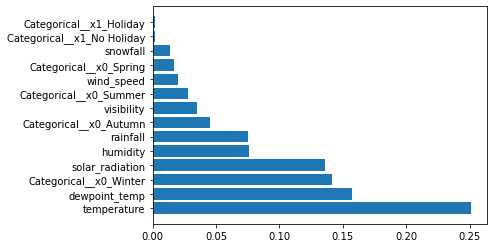

In [30]:
#sorting them
sorted_features = []
for feature, importance in zip(X.columns, tuned_model.feature_importances_):
    sorted_features.append((feature, importance))
sorted_features.sort(key = lambda x: x[1], reverse = True)
plt.barh([x[0] for x in sorted_features], [y[1] for y in sorted_features])
plt.xticks(rotation='horizontal')
plt.show()

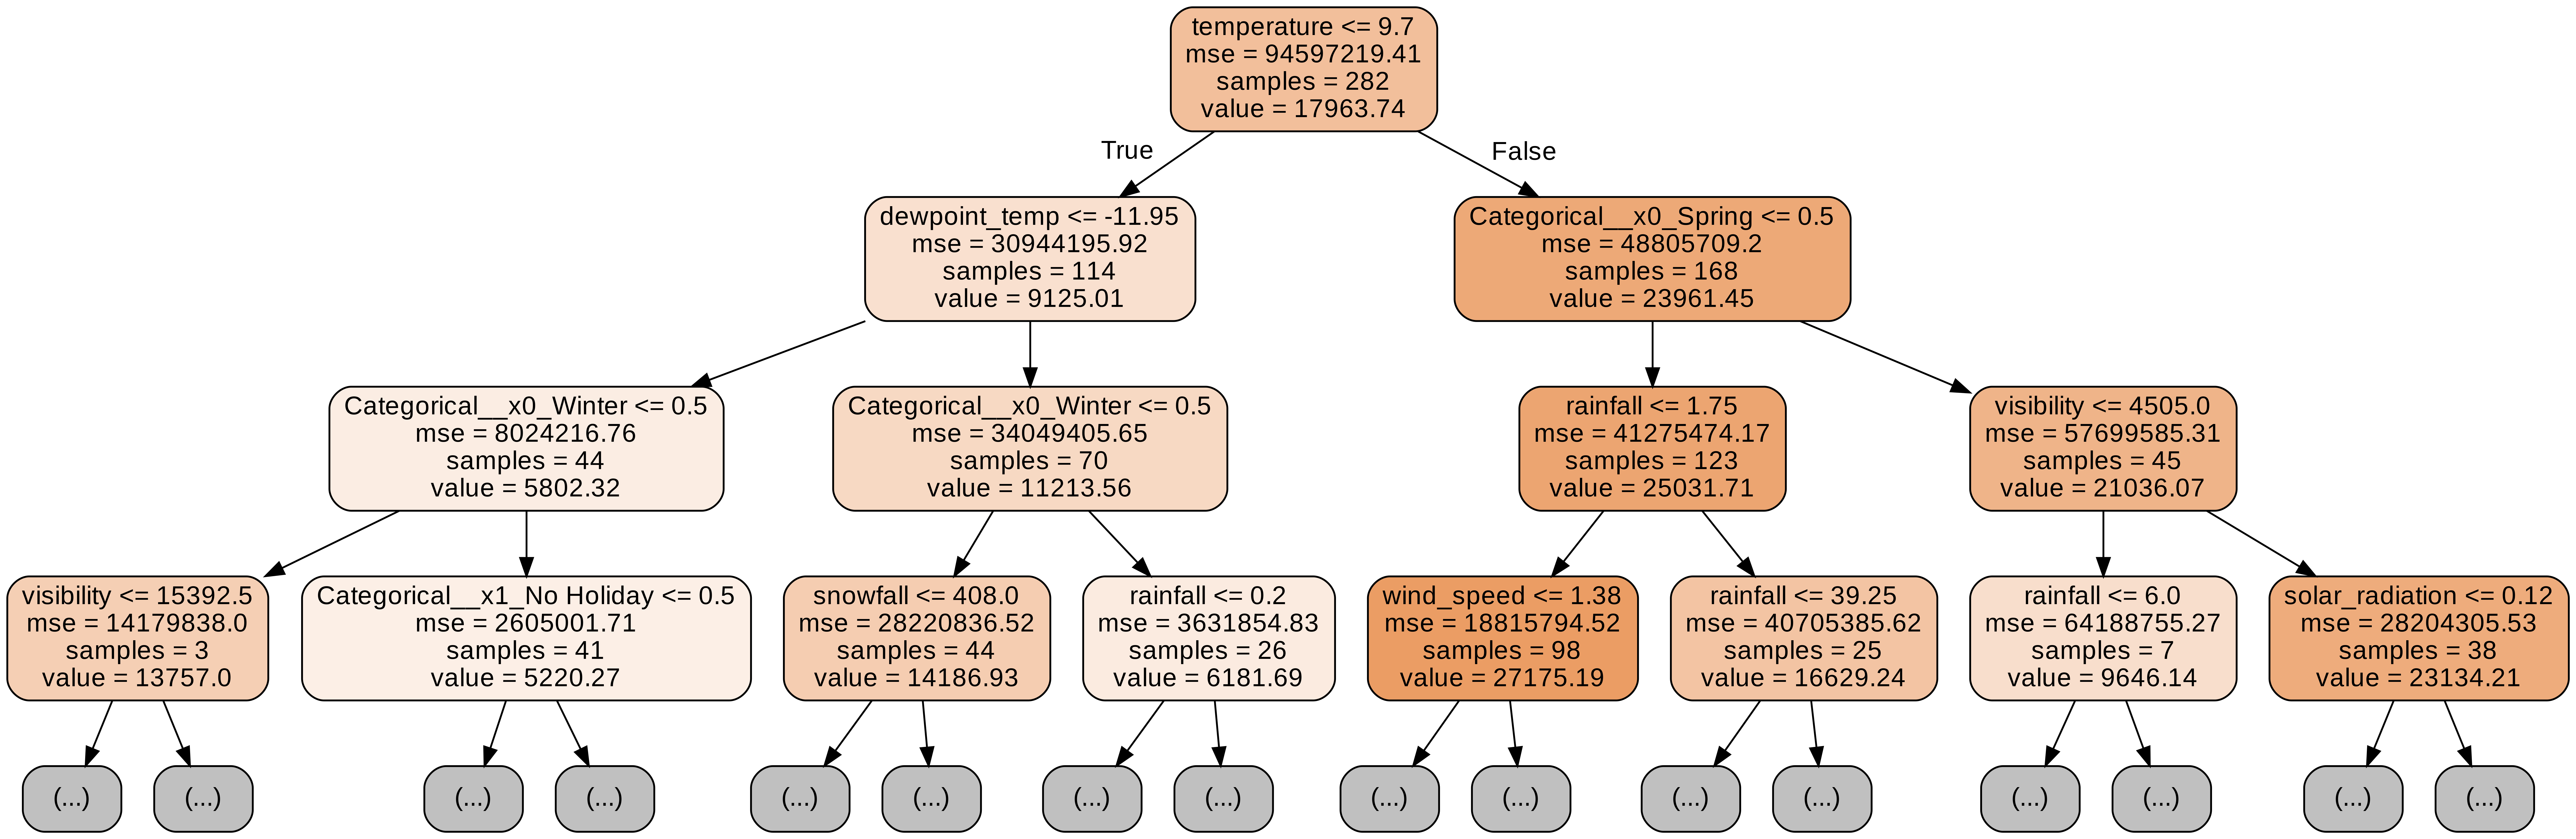

In [34]:
# Export as dot file
export_graphviz(tuned_model.estimators_[1], out_file='tree.dot', 
                feature_names = X_column_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth =3)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:
pip install shap

     |████████████████████████████████| 356 kB 5.4 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491654 sha256=e079e0f2e426a89e42251b7622528508459bf307ef260b44324a2783048b9b63
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


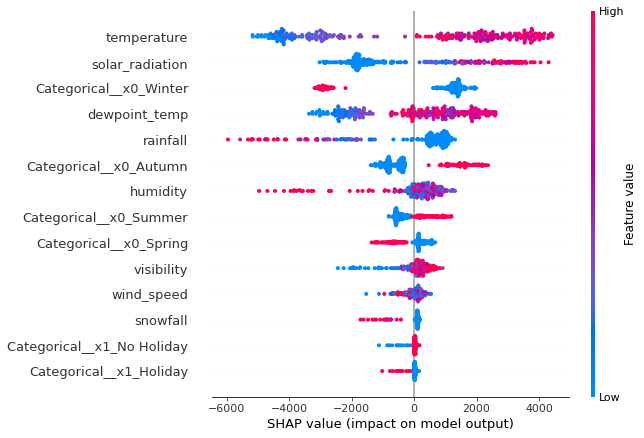

In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(tuned_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

#Saving / Loading the model

In [36]:
'''
pkl_filename = "pickle_model.pkl"
file_directory = 'Add the path of your google drive folder'

# Save to file in the current working directory
with open(file_directory + pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# Load from file
with open(file_directory + pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
'''

'\npkl_filename = "pickle_model.pkl"\nfile_directory = \'Add the path of your google drive folder\'\n\n# Save to file in the current working directory\nwith open(file_directory + pkl_filename, \'wb\') as file:\n    pickle.dump(model, file)\n\n# Load from file\nwith open(file_directory + pkl_filename, \'rb\') as file:\n    pickle_model = pickle.load(file)\n'